In [1]:
# Kaggle TPU Setup Script
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import shutil, cv2, gc, glob, joblib, os, random, sys, warnings, zipfile, concurrent.futures

from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

from skimage.transform import resize

from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, roc_auc_score, f1_score, multilabel_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.utils import class_weight

warnings.filterwarnings('ignore')

sns.set()  # For plotting

# Kaggle-specific TPU initialization
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # Detect TPU
    print('Running on TPU: ', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
    print("TPU successfully initialized")
except ValueError:
    print('Not connected to a TPU')

# TensorFlow version check
!python --version

E0000 00:00:1731055685.560100      13 common_lib.cc:798] Could not set metric server port: INVALID_ARGUMENT: Could not find SliceBuilder port 8471 in any of the 0 ports provided in `tpu_process_addresses`="local"
=== Source Location Trace: ===
learning/45eac/tfrc/runtime/common_lib.cc:479
D1108 08:48:05.568275895      13 config.cc:196]                        gRPC EXPERIMENT call_status_override_on_cancellation   OFF (default:OFF)
D1108 08:48:05.568291293      13 config.cc:196]                        gRPC EXPERIMENT call_v3                                OFF (default:OFF)
D1108 08:48:05.568294570      13 config.cc:196]                        gRPC EXPERIMENT canary_client_privacy                  ON  (default:ON)
D1108 08:48:05.568296946      13 config.cc:196]                        gRPC EXPERIMENT capture_base_context                   ON  (default:ON)
D1108 08:48:05.568299427      13 config.cc:196]                        gRPC EXPERIMENT client_idleness                        ON  (defau

Running on TPU:  
INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.
INFO:tensorflow:Initializing the TPU system: local


I0000 00:00:1731055698.536627      13 service.cc:145] XLA service 0x5cd58af414e0 initialized for platform TPU (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731055698.536715      13 service.cc:153]   StreamExecutor device (0): TPU, 2a886c8
I0000 00:00:1731055698.536720      13 service.cc:153]   StreamExecutor device (1): TPU, 2a886c8
I0000 00:00:1731055698.536723      13 service.cc:153]   StreamExecutor device (2): TPU, 2a886c8
I0000 00:00:1731055698.536726      13 service.cc:153]   StreamExecutor device (3): TPU, 2a886c8
I0000 00:00:1731055698.536728      13 service.cc:153]   StreamExecutor device (4): TPU, 2a886c8
I0000 00:00:1731055698.536731      13 service.cc:153]   StreamExecutor device (5): TPU, 2a886c8
I0000 00:00:1731055698.536733      13 service.cc:153]   StreamExecutor device (6): TPU, 2a886c8
I0000 00:00:1731055698.536736      13 service.cc:153]   StreamExecutor device (7): TPU, 2a886c8


INFO:tensorflow:Finished initializing TPU system.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)
I

In [2]:
os.makedirs("/kaggle/working/models", exist_ok=True)
# Define the paths for part 1 and part 2
part_1_path = '/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1'
part_2_path = '/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_2'
combined_path = '/kaggle/working/combined'

# Create a directory to store the combined images
os.makedirs(combined_path, exist_ok=True)

# Copy images from part 1
for img_file in os.listdir(part_1_path):
    shutil.copy(os.path.join(part_1_path, img_file), combined_path)

# Copy images from part 2
for img_file in os.listdir(part_2_path):
    shutil.copy(os.path.join(part_2_path, img_file), combined_path)

# Verify the combined directory
print("Combined directory contains:", len(os.listdir(combined_path)), "files.")


Combined directory contains: 10015 files.


In [3]:
# Environment
csvMetadataPath = "/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_metadata.csv" 
imagesPath = "/kaggle/working/combined/" 
savePath = "/kaggle/working/models/" 
saveName = "convNeXt"      
# Model architecture
architecture = "resnet50"
# Height and weight of images to be crop
h, w = 224,224
# Transfer learning from imagenet
transferLearning = True        
freezeLayers = True        

# Remove duplicates
# False = 10015 images, True = 7470 images
removeDuplicates = True         
balanceClasses = False           

# Segmentation
segmentation = False

# Data augmentation
dataAugmentation = False        
rotation = .45                  
widthShift = 0.1                
heightShift = 0.1               
channelShift = .15              
shear = .2                      
zoom = 0.05                     
hFlip,vFlip = True,True         
fill = 'nearest'                
#Case the previous is constant
cval = .5                       
minBright = 0.1                 
maxBright = 1.1                 
bright = [minBright,maxBright]

# Normalization
featureCenter = False           
sampleCenter = False            
featureStdNorm = False          
sampleStdNorm = False           
zcaWhitening = False            
# Separate from imageDataGenerator
standardScalerNorm = False      
minMaxScalerNorm = False        

# Model configuration
epochs = 10                     
batchSize = 8                   
customOptimizer = False        
useCallback = False             

cancerType = {
    'akiec': 0, # 0.0 - 'Doenca de Bowens'
    'bcc': 1, # 1.0 - 'Carcinoma basocelular'
    'bkl': 2, # 2.0 - 'Keratose benigna'
    'df': 3, # 3.0 - 'Dermatofibroma'
    'vasc': 4, # 4.0 - 'Lesao vascular'
    'mel': 5, # 5.0 - 'Melanoma'
    'nv': 6  # 6.0 - 'Nevo melanocitico'
}
totalClasses = len(cancerType)

In [4]:
datasetMetadata = pd.read_csv(csvMetadataPath)
datasetMetadata = datasetMetadata.drop(columns=['dx_type','age','sex','localization']) # Non-utilized columns
datasetMetadata = datasetMetadata.rename(columns={"lesion_id": "lesionId",
                                                  "image_id": "imageId",
                                                  "dx": "cancerId"})
datasetMetadata.head()

,lesionId,imageId,cancerId
0,HAM_0000118,ISIC_0027419,bkl
1,HAM_0000118,ISIC_0025030,bkl
2,HAM_0002730,ISIC_0026769,bkl
3,HAM_0002730,ISIC_0025661,bkl
4,HAM_0001466,ISIC_0031633,bkl


In [5]:
datasetMetadata['duplicate'] = datasetMetadata['lesionId']      # Creating a column to indicate if the lesion has more than one image

uniqueLesions = datasetMetadata.groupby('lesionId').count()     # Counts the number of lesions for each id
uniqueLesions = uniqueLesions[uniqueLesions['imageId'] == 1]    # Filter lesions which ones have unique id
uniqueLesions.reset_index(inplace = True)                       # Add default index column
uniqueLesions = uniqueLesions['lesionId'].values.tolist()       # Extracts the indexes into a list

datasetMetadata['duplicate'] = datasetMetadata['lesionId'].apply(lambda x: False if x in uniqueLesions else True) # Fill the rows indicating if the lesion has a duplicated image
datasetMetadata['duplicate'].value_counts()
del uniqueLesions

In [6]:
if removeDuplicates: # Adjusted to get only one of the duplicates and non duplicates
    datasetMetadata = datasetMetadata[~((datasetMetadata['lesionId'].duplicated()) & (datasetMetadata['duplicate']))]
datasetMetadata.head()

,lesionId,imageId,cancerId,duplicate
0,HAM_0000118,ISIC_0027419,bkl,True
2,HAM_0002730,ISIC_0026769,bkl,True
4,HAM_0001466,ISIC_0031633,bkl,True
6,HAM_0002761,ISIC_0029176,bkl,True
8,HAM_0005132,ISIC_0025837,bkl,True


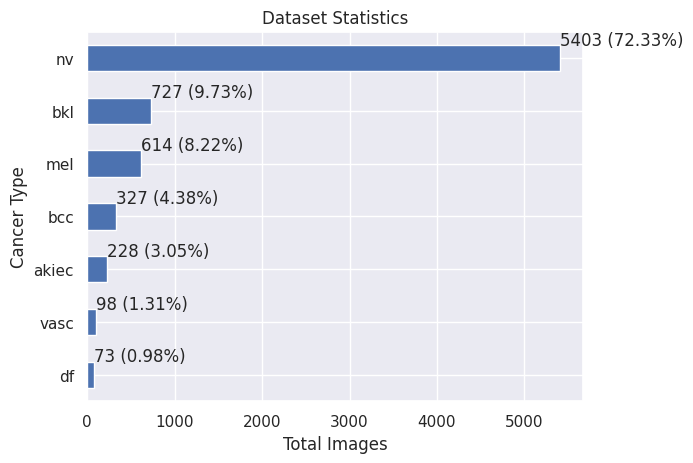

cancerId
df         73
vasc       98
akiec     228
bcc       327
mel       614
bkl       727
nv       5403
dtype: int64
Total:  7470


In [7]:
labelSize = datasetMetadata.groupby('cancerId').size().sort_values() # Sort and order every cancer class

ax = labelSize.plot.barh()

for i, v in enumerate(labelSize):
    ax.text(v + 3, i + .25, str(v) + ' (' + str(round(v/datasetMetadata.shape[0]*100, 2)) + '%)') # Set the percentage of each cancer class
plt.title('Dataset Statistics')
plt.ylabel('Cancer Type')
plt.xlabel('Total Images')
plt.show()

print(labelSize)
print("Total: ", labelSize.sum())
del labelSize

In [8]:
datasetMetadata['cancerId'] = datasetMetadata['cancerId'].map(cancerType) # Map each class into an integer
datasetMetadata.head()

,lesionId,imageId,cancerId,duplicate
0,HAM_0000118,ISIC_0027419,2,True
2,HAM_0002730,ISIC_0026769,2,True
4,HAM_0001466,ISIC_0031633,2,True
6,HAM_0002761,ISIC_0029176,2,True
8,HAM_0005132,ISIC_0025837,2,True


In [9]:
# Function to process a single image
def process_image(row, imagesPath, h, w):
    image_path = ''.join([imagesPath, row['imageId'], '.jpg'])

    # Check if the image exists, handle missing or corrupted files
    if not os.path.isfile(image_path):
        print(f"Warning: Image not found at {image_path}")
        return None

    img = cv2.imread(image_path)  # Load the image
    if img is None:
        print(f"Error: Could not load image at {image_path}")
        return None

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    img = cv2.resize(img, (h, w))  # Resize image
    return img

# Parallel processing function
def load_images_in_parallel(datasetMetadata, imagesPath, h, w, max_workers=8):
    images = []
    total_images = len(datasetMetadata)

    # Use ThreadPoolExecutor to process images in parallel
    with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as executor:
        # Submit tasks to the executor
        futures = [executor.submit(process_image, row, imagesPath, h, w) for index, row in datasetMetadata.iterrows()]

        # Gather results as they complete
        for loadedImages, future in enumerate(concurrent.futures.as_completed(futures), 1):
            img = future.result()
            if img is not None:
                images.append(img)

            if loadedImages % 1000 == 0 or loadedImages == total_images:
                print(f"{loadedImages}/{total_images} images processed")

    return images

# Call the function
images = load_images_in_parallel(datasetMetadata, imagesPath, h, w, max_workers=8)

1000/7470 images processed
2000/7470 images processed
3000/7470 images processed
4000/7470 images processed
5000/7470 images processed
6000/7470 images processed
7000/7470 images processed
7470/7470 images processed


7470
lesionId      HAM_0000118
imageId      ISIC_0027419
cancerId                2
duplicate            True
Name: 0, dtype: object
(224, 224, 3)


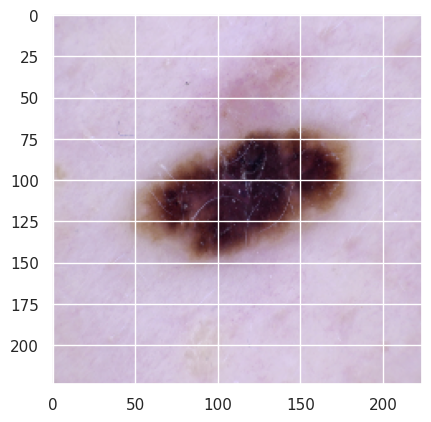

In [10]:
plt.imshow(images[0])
print(len(images))
print(datasetMetadata.iloc[0])
print(images[0].shape)
plt.show()

In [11]:
XTrainVal, XTest, YTrainVal, YTest = train_test_split(images,
                                                      datasetMetadata['cancerId'],
                                                      test_size = 0.2,
                                                      train_size = 0.8,
                                                      stratify = datasetMetadata['cancerId'])
del images, datasetMetadata
XTrain, XVal, YTrain, YVal = train_test_split(XTrainVal,
                                              YTrainVal,
                                              test_size = 0.125,
                                              train_size = 0.875,
                                              stratify = YTrainVal)
del XTrainVal, YTrainVal

print('Train set size: ', YTrain.size)
print('Validation set size: ', YVal.size)
print('Test set size: ', YTest.size)

Train set size:  5229
Validation set size:  747
Test set size:  1494


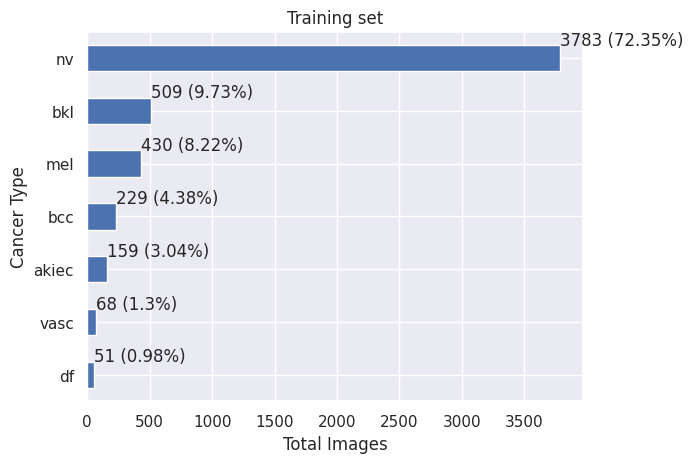

In [12]:
labelSize = YTrain.value_counts()
labelSize.index = labelSize.index.map(lambda x: list(cancerType.keys())[list(cancerType.values()).index(x)])
labelSize = labelSize.sort_values()

ax = labelSize.plot.barh()

for i, v in enumerate(labelSize):
    ax.text(v + 3, i + .25, str(v) + ' (' + str(round(v/YTrain.shape[0]*100, 2)) + '%)')
plt.title('Training set')
plt.ylabel('Cancer Type')
plt.xlabel('Total Images')
plt.show()

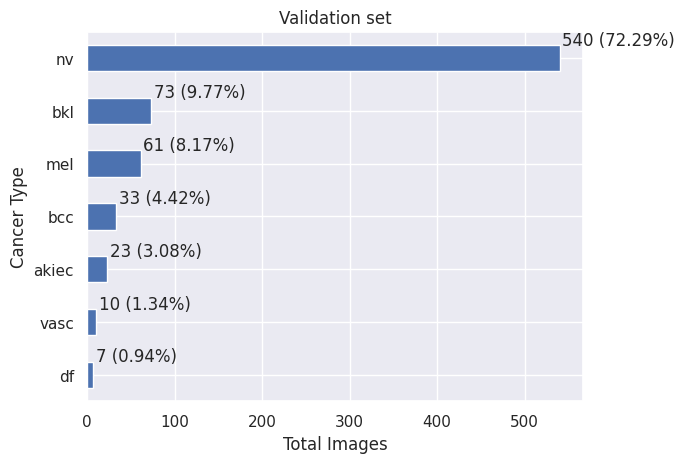

In [13]:
labelSize = YVal.value_counts()
labelSize.index = labelSize.index.map(lambda x: list(cancerType.keys())[list(cancerType.values()).index(x)])
labelSize = labelSize.sort_values()

ax = labelSize.plot.barh()

for i, v in enumerate(labelSize):
    ax.text(v + 3, i + .25, str(v) + ' (' + str(round(v/YVal.shape[0]*100, 2)) + '%)')
plt.title('Validation set')
plt.ylabel('Cancer Type')
plt.xlabel('Total Images')
plt.show()

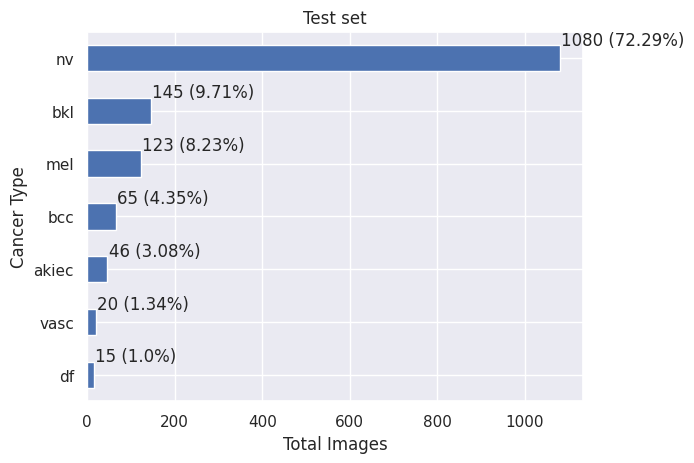

In [14]:
labelSize = YTest.value_counts()
labelSize.index = labelSize.index.map(lambda x: list(cancerType.keys())[list(cancerType.values()).index(x)])
labelSize = labelSize.sort_values()

ax = labelSize.plot.barh()

for i, v in enumerate(labelSize):
    ax.text(v + 3, i + .25, str(v) + ' (' + str(round(v/YTest.shape[0]*100, 2)) + '%)')
plt.title('Test set')
plt.ylabel('Cancer Type')
plt.xlabel('Total Images')
plt.show()
del labelSize, ax

In [15]:
if dataAugmentation:
    datagen = ImageDataGenerator(
        # Normalizations
        featurewise_center = featureCenter,
        samplewise_center = sampleCenter,
        featurewise_std_normalization = featureStdNorm,
        samplewise_std_normalization = sampleStdNorm,
        zca_whitening = zcaWhitening,
        # Image modifications
        rotation_range = rotation,
        zoom_range = zoom,
        channel_shift_range = channelShift,
        fill_mode = fill,
        cval = cval,
        width_shift_range = widthShift,
        height_shift_range = heightShift,
        horizontal_flip = hFlip,
        brightness_range = bright,
        shear_range = shear,
        vertical_flip = vFlip
    )
    if featureCenter or featureStdNorm or zcaWhitening:
        datagen.fit(XTrain)

In [16]:
if dataAugmentation:
    batch_sizes = {
        0: 23,
        1: 15,
        2: 6,
        3: 73,
        4: 55,
        5: 9,
        6: 0
    }
    augmented_images = []
    augmented_labels = []
    for image, label in zip(XTrain, YTrain):
        augmented_images.append(image)
        augmented_labels.append(label)

        if batch_sizes[label] > 0:
            image = np.expand_dims(image, axis=0)  # 3D -> 4D
            augmented = datagen.flow(image, batch_size=batch_sizes[label]) # Generate the image batch

            for i in range(batch_sizes[label]): # Iterate over the batch and append the images
                augmented_images.append(np.squeeze(next(augmented), axis=0).astype('uint8'))
                augmented_labels.append(label)

    XTrain = augmented_images
    YTrain = pd.Series(augmented_labels)
    del augmented_labels, augmented_images, batch_sizes

In [17]:
if dataAugmentation:
    labelSize = YTrain.value_counts()
    labelSize.index = labelSize.index.map(lambda x: list(cancerType.keys())[list(cancerType.values()).index(x)])
    labelSize = labelSize.sort_values()

    ax = labelSize.plot.barh()

    for i, v in enumerate(labelSize):
        ax.text(v + 3, i + .25, str(v) + ' (' + str(round(v/YTrain.shape[0]*100, 2)) + '%)')
    plt.title('Training Set With Data Augmentation')
    plt.ylabel('Cancer Type')
    plt.xlabel('Total')
    plt.show()
    del labelSize, ax

In [18]:
def segmentImg(img, alpha = 1.0, kernelMask = (5, 5), kernelSoftMask = (21, 21)):
    grayImg = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    softenedImg = cv2.GaussianBlur(grayImg, kernelMask, 0)                                # Apply softened filter to reduce noise
    _, mask = cv2.threshold(softenedImg, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU) # Thresholding algorithm to create mask
    softenedMask = cv2.GaussianBlur(mask, kernelSoftMask, 0)                              # Smoothing filter
    segmentedImg = cv2.bitwise_and(img, img, mask = softenedMask)                         # Apply mask
    beta = 1.0 - alpha # Beta = weight for original image, alpha = Weight for segmented image - 0 for highlight only the lesion, 1 for original image
    return cv2.addWeighted(img, alpha, segmentedImg, beta, 0)                             # Merge segmented image and original image weighted

def segmentImgList(imgs):
    for i in range(len(imgs)):
        imgs[i] = segmentImg(imgs[i])
    return imgs

if segmentation:
    XTrain = segmentImgList(XTrain)
    XVal = segmentImgList(XVal)
    XTest = segmentImgList(XTest)

In [19]:
XTrain = np.array(XTrain)
XTrain = XTrain.reshape(XTrain.shape[0], h * w * 3) # 4d -> 2d

XVal = np.array(XVal)
XVal = XVal.reshape(XVal.shape[0], h * w * 3) # 4d -> 2d

XTest = np.array(XTest)
XTest = XTest.reshape(XTest.shape[0], h * w * 3) # 4d -> 2d

In [20]:
if minMaxScalerNorm:
    minMaxScaler = MinMaxScaler()
    minMaxScaler.fit(np.asarray(XTrain))

    XTrain = minMaxScaler.transform(XTrain)
    XVal = minMaxScaler.transform(XVal)
    XTest = minMaxScaler.transform(XTest)
elif standardScalerNorm:
    standardScaler = StandardScaler()
    standardScaler.fit(np.asarray(XTrain))

    XTrain = standardScaler.transform(XTrain)
    XVal = standardScaler.transform(XVal)
    XTest = standardScaler.transform(XTest)

print(np.shape(XTest))
print(np.shape(XTrain))
print(np.shape(XVal))
print(YTrain.head())

(1494, 150528)
(5229, 150528)
(747, 150528)
6385    6
3016    6
5023    6
2139    5
4222    6
Name: cancerId, dtype: int64


In [21]:
# Print the number of samples in train, validation, and test sets
print("Training samples:", XTrain.shape[0])
print("Validation samples:", XVal.shape[0])
print("Test samples:", XTest.shape[0])

# Reshape the datasets to match the input shape of the model (height, width, channels)
XTrain = XTrain.reshape(XTrain.shape[0], h, w, 3).astype('float32')
XVal = XVal.reshape(XVal.shape[0], h, w, 3).astype('float32')
XTest = XTest.reshape(XTest.shape[0], h, w, 3).astype('float32')

# Convert class labels to one-hot encoding using to_categorical
from tensorflow.keras.utils import to_categorical
YTrain = to_categorical(YTrain)
YVal = to_categorical(YVal)
YTest = to_categorical(YTest)

# Print the shape of the first training image to confirm the correct dimensions
print("Shape of the first training sample:", XTrain[0].shape)

# Print the dtype of XTrain
print("Data type of XTrain:", XTrain.dtype)


Training samples: 5229
Validation samples: 747
Test samples: 1494
Shape of the first training sample: (224, 224, 3)
Data type of XTrain: float32


In [22]:
# Make sure the code runs within the TPU strategy
with strategy.scope():  # Using TPU for model training
    # Define the model architecture based on user selection
    match architecture:
        case "resnet50":
            model = tf.keras.applications.ResNet50(classes=totalClasses,
                                                     include_top=False,
                                                     input_shape=(h, w, 3),
                                                     weights='imagenet' if transferLearning else None)
        case _:
            raise Exception("Model not configured or non-existent")

    # Freeze layers if specified
    if freezeLayers:
        for layer in model.layers:
            layer.trainable = False

    # Final model with added output layers
    model = tf.keras.Model(inputs=model.input,
                           outputs=tf.keras.layers.Dense(totalClasses,
                                                         activation='softmax')(
                               tf.keras.layers.Flatten()(model.output)))

    # Compile the model with custom optimizer if specified
    if customOptimizer:
        model.compile(optimizer=AdamW(amsgrad=True,
                                      beta_1=0.9 if transferLearning else 0.8,
                                      beta_2=0.999 if transferLearning else 0.99,
                                      lr=0.00001 if transferLearning else 0.001,
                                      weight_decay=0.04 if dataAugmentation else 0.0004),
                      loss="categorical_crossentropy",
                      metrics=[tf.keras.metrics.Accuracy(),
                               tf.keras.metrics.AUC(),
                               tf.keras.metrics.Recall(),
                               tf.keras.metrics.Precision(),
                               tf.keras.metrics.FalsePositives(),
                               tf.keras.metrics.FalseNegatives(),
                               tf.keras.metrics.TrueNegatives(),
                               tf.keras.metrics.TruePositives()])
    else:
        # Use Adam optimizer if no custom optimizer is specified
        model.compile(optimizer="adam",
                      loss="categorical_crossentropy",
                      metrics=[tf.keras.metrics.Accuracy(),
                               tf.keras.metrics.AUC(),
                               tf.keras.metrics.Recall(),
                               tf.keras.metrics.Precision(),
                               tf.keras.metrics.FalsePositives(),
                               tf.keras.metrics.FalseNegatives(),
                               tf.keras.metrics.TrueNegatives(),
                               tf.keras.metrics.TruePositives()])

# Model is now ready to train with TPU acceleration


I0000 00:00:1731055791.131292      13 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [23]:
gc.collect()
plt.close('all')

In [24]:
with strategy.scope():  # Use TPU strategy scope

    history = model.fit(batch_size = batchSize,
                        callbacks = [EarlyStopping(min_delta = 0.001, monitor = 'val_loss', patience=3)] if useCallback else None,
                        class_weight = dict(enumerate(class_weight.compute_class_weight(class_weight = 'balanced',
                                                                                        classes = np.unique(YTrain.argmax(axis=1)),
                                                                                        y = YTrain.argmax(axis=1)))) if balanceClasses else None,
                        epochs = epochs,
                        validation_data = (XVal, YVal),
                        verbose = 2,
                        x = XTrain,
                        y = YTrain)

Epoch 1/10


2024-11-08 08:50:21.239999: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node StatefulPartitionedCall.
I0000 00:00:1731055822.137365     821 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(3e15e639ecb76996:0:0), session_name()
I0000 00:00:1731055829.334966     821 tpu_compile_op_common.cc:245] Compilation of 3e15e639ecb76996:0:0 with session name  took 7.197017104s and succeeded
I0000 00:00:1731055829.349263     821 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(3e15e639ecb76996:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_9209435255770389035", property.function_library_fingerprint = 4298322391459402937, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 

654/654 - 39s - 59ms/step - accuracy: 0.5205 - auc: 0.8520 - false_negatives: 187.0000 - false_positives: 185.0000 - loss: 10.1747 - precision: 0.7163 - recall: 0.7141 - true_negatives: 3739.0000 - true_positives: 467.0000 - val_accuracy: 0.6429 - val_auc: 0.8745 - val_false_negatives: 23.0000 - val_false_positives: 23.0000 - val_loss: 9.9952 - val_precision: 0.7553 - val_recall: 0.7553 - val_true_negatives: 541.0000 - val_true_positives: 71.0000
Epoch 2/10
654/654 - 16s - 24ms/step - accuracy: 0.7615 - auc: 0.9353 - false_negatives: 80.0000 - false_positives: 80.0000 - loss: 3.7391 - precision: 0.8777 - recall: 0.8777 - true_negatives: 3844.0000 - true_positives: 574.0000 - val_accuracy: 0.7173 - val_auc: 0.8950 - val_false_negatives: 17.0000 - val_false_positives: 17.0000 - val_loss: 8.7125 - val_precision: 0.8191 - val_recall: 0.8191 - val_true_negatives: 547.0000 - val_true_positives: 77.0000
Epoch 3/10
654/654 - 15s - 23ms/step - accuracy: 0.7995 - auc: 0.9514 - false_negatives: 6

In [25]:
del XTrain, YTrain
gc.collect()

102527

In [26]:
YPredicted = model.predict(XTest)
print('Test set evaluation: ', model.evaluate(XTest, YTest, verbose = 0))
print('Validation set evaluation: ', model.evaluate(XVal, YVal, verbose = 0))

2024-11-08 08:53:16.022110: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node functional_1/conv1_bn_1/Cast/ReadVariableOp.
I0000 00:00:1731055996.415002     768 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(469b9b1731bd60a0:0:0), session_name()


 3/47 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step

I0000 00:00:1731056003.376949     768 tpu_compile_op_common.cc:245] Compilation of 469b9b1731bd60a0:0:0 with session name  took 6.961890487s and succeeded
I0000 00:00:1731056003.386473     768 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(469b9b1731bd60a0:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_distributed_17081668352334118287", property.function_library_fingerprint = 4788722551070645916, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1731056003.386509     768 tpu_compilation_cache_interface.cc:541] After adding entry for key 469b9b1731b

46/47 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step

I0000 00:00:1731056008.667991     811 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(4c42d9aa914799b5:0:0), session_name()


47/47 ━━━━━━━━━━━━━━━━━━━━ 23s 298ms/step


I0000 00:00:1731056017.096851     811 tpu_compile_op_common.cc:245] Compilation of 4c42d9aa914799b5:0:0 with session name  took 8.428816412s and succeeded
I0000 00:00:1731056017.107492     811 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(4c42d9aa914799b5:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_distributed_37810405873264970", property.function_library_fingerprint = 1711576973501823304, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "3,224,224,3,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1731056017.107529     811 tpu_compilation_cache_interface.cc:541] After adding entry for key 4

Test set evaluation:  [20.39512825012207, 0.8785332441329956, 0.8995157480239868, 0.8128342032432556, 0.8128342032432556, 35.0, 35.0, 1087.0, 152.0]
Validation set evaluation:  [20.11100196838379, 0.8662614226341248, 0.8814414739608765, 0.7872340679168701, 0.7872340679168701, 20.0, 20.0, 544.0, 74.0]


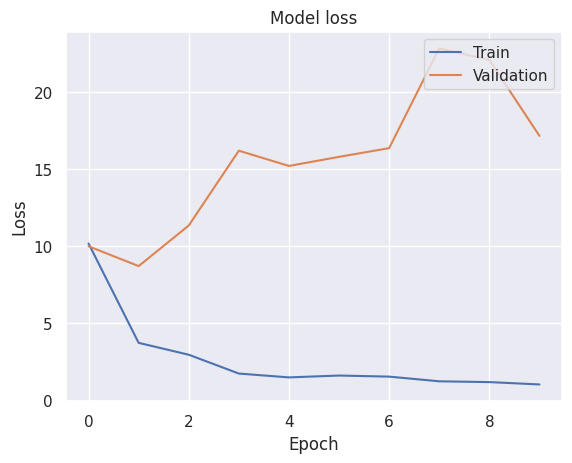

In [27]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc = 'upper right')
plt.show()

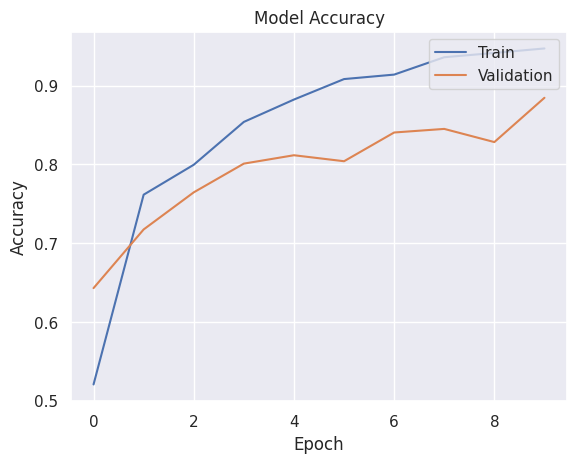

In [28]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc = 'upper right')
plt.show()

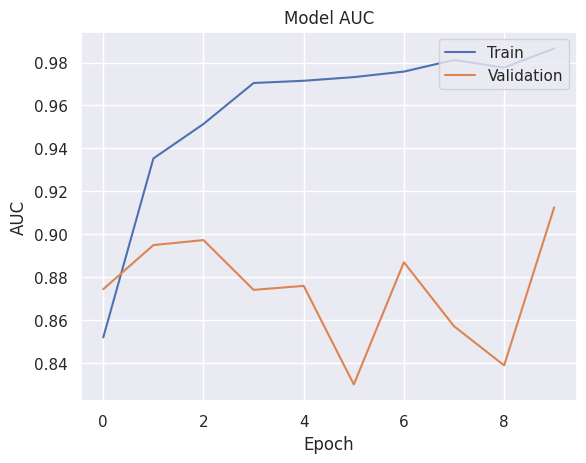

In [29]:
plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])
plt.title('Model AUC')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc = 'upper right')
plt.show()

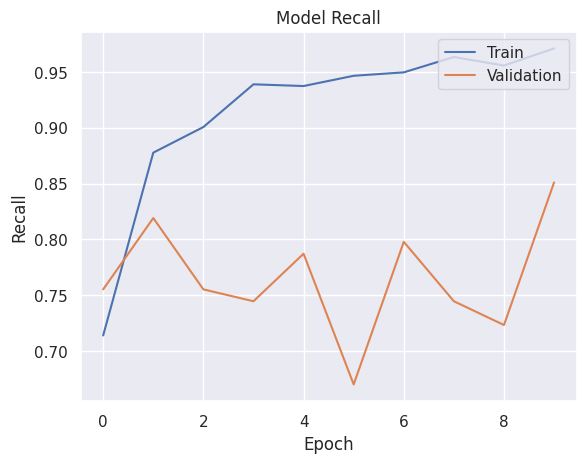

In [30]:
plt.plot(history.history['recall'])
plt.plot(history.history['val_recall'])
plt.title('Model Recall')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc = 'upper right')
plt.show()

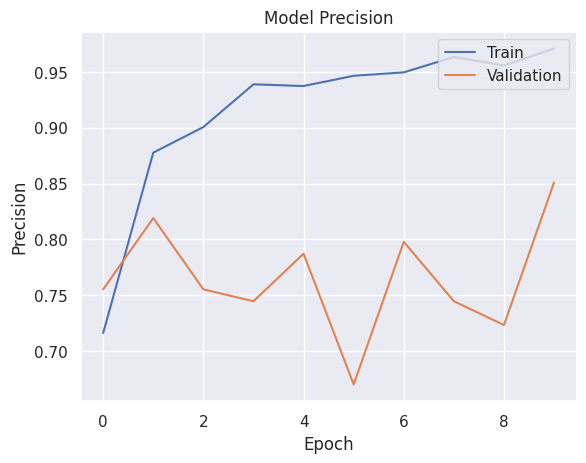

In [31]:
plt.plot(history.history['precision'])
plt.plot(history.history['val_precision'])
plt.title('Model Precision')
plt.ylabel('Precision')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc = 'upper right')
plt.show()

34748

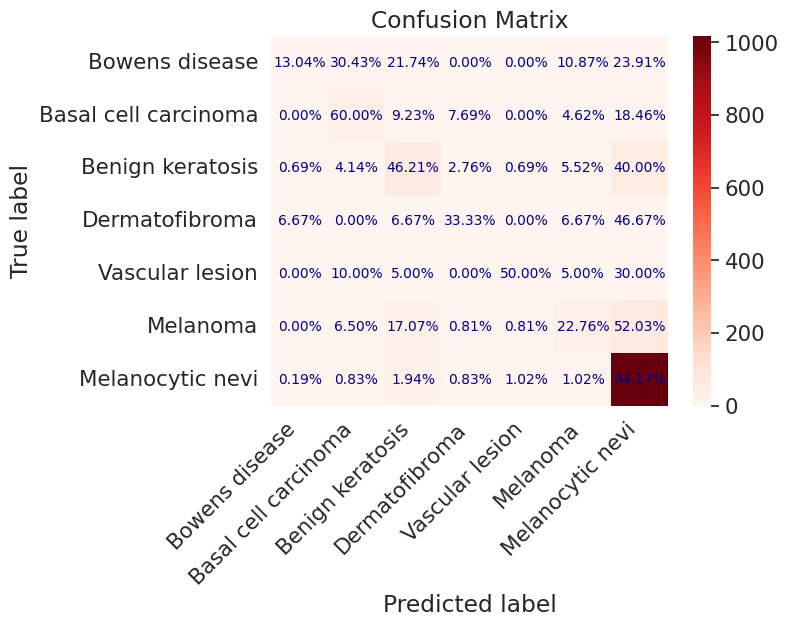

In [32]:
cm = confusion_matrix(YTest.argmax(axis = 1), YPredicted.argmax(axis = 1))

labels = ['Bowens disease',
          'Basal cell carcinoma',
          'Benign keratosis',
          'Dermatofibroma',
          'Vascular lesion',
          'Melanoma',
          'Melanocytic nevi']
dfCm = pd.DataFrame(cm, index = labels, columns = labels)

sns.set(font_scale = 1.4) # Label size
sns.heatmap(dfCm, annot = False, cmap = "Reds", annot_kws = {"size": 14}) # Font size

for i in range(totalClasses):
    for j in range(totalClasses):
        text = plt.text(j + 0.5, i + 0.5, f"{cm[i, j] / cm[i].sum() * 100:.2f}%", # {cm[i, j]:0d} ({cm[i, j] / cm[i].sum() * 100:.2f}%)
                        va = "center",
                        ha = "center",
                        color = "darkBlue",
                        fontsize = 10)

ax = plt.gca()
ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, ha = 'right')

plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
del ax, cm, dfCm
gc.collect()

In [33]:
metrics = {
    'Precision': precision_score(YTest.argmax(axis=1), YPredicted.argmax(axis=1), average=None),
    'F1-score': f1_score(YTest.argmax(axis=1), YPredicted.argmax(axis=1), average=None),
    'ROC AUC': roc_auc_score(YTest, YPredicted, average=None),
    'Recall': recall_score(YTest.argmax(axis=1), YPredicted.argmax(axis=1), average=None)
}

cmMulti = multilabel_confusion_matrix(YTest.argmax(axis=1), YPredicted.argmax(axis=1))
specificity = []
for i in range(len(cmMulti)):
    tn = cmMulti[i][0][0]
    specificity.append(tn / (tn + cmMulti[i][0][1]))
metrics[f'Specificity'] = specificity

metrics[f'Confusion_Matrix'] = cmMulti
del cmMulti, specificity

Precision:

       Label            Value  
      Bowens disease  0.600000 
Basal cell carcinoma  0.500000 
    Benign keratosis  0.527559 
      Dermatofibroma  0.208333 
     Vascular lesion  0.434783 
            Melanoma  0.491228 
    Melanocytic nevi  0.865532 


F1-score:

       Label            Value  
      Bowens disease  0.214286 
Basal cell carcinoma  0.545455 
    Benign keratosis  0.492647 
      Dermatofibroma  0.256410 
     Vascular lesion  0.465116 
            Melanoma  0.311111 
    Melanocytic nevi  0.901996 


ROC AUC:

       Label            Value  
      Bowens disease  0.749782 
Basal cell carcinoma  0.886435 
    Benign keratosis  0.807019 
      Dermatofibroma  0.772414 
     Vascular lesion  0.910550 
            Melanoma  0.725202 
    Melanocytic nevi  0.808873 


Recall:

       Label            Value  
      Bowens disease  0.130435 
Basal cell carcinoma  0.600000 
    Benign keratosis  0.462069 
      Dermatofibroma  0.333333 
     Vascular lesion  0.

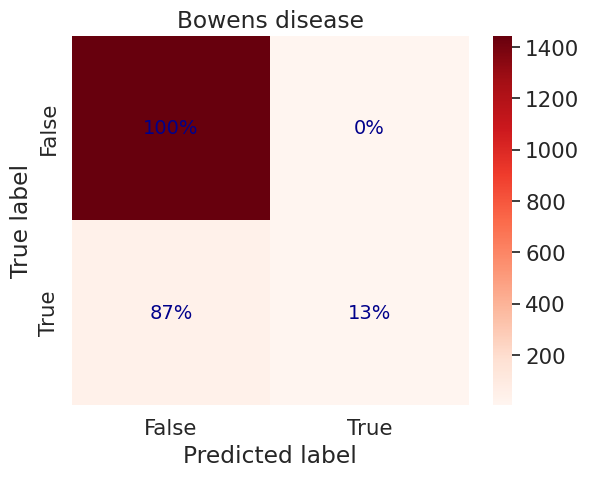

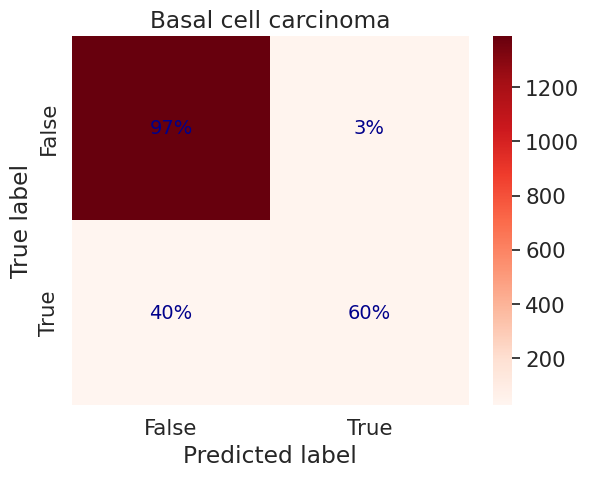

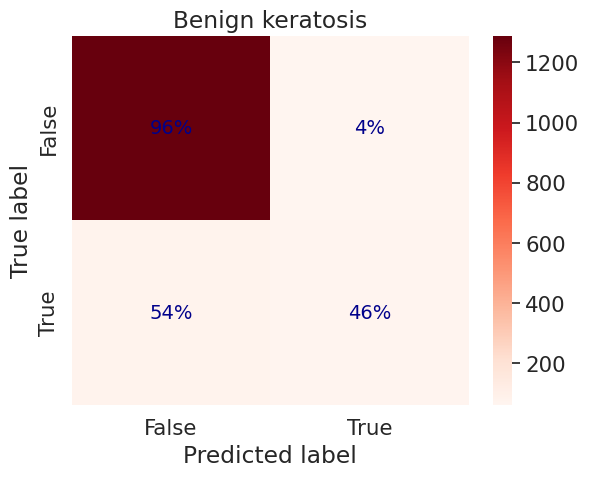

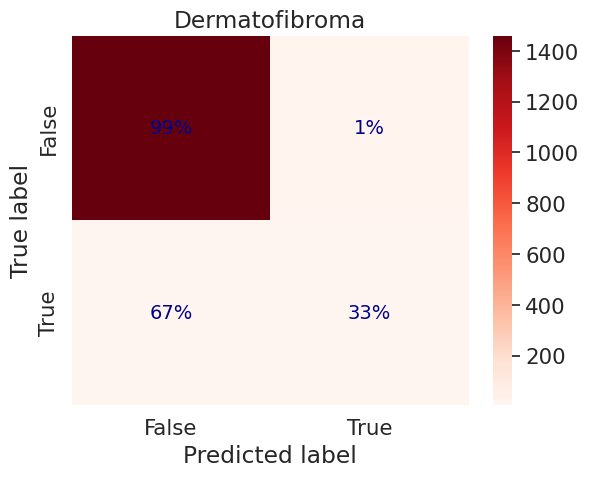

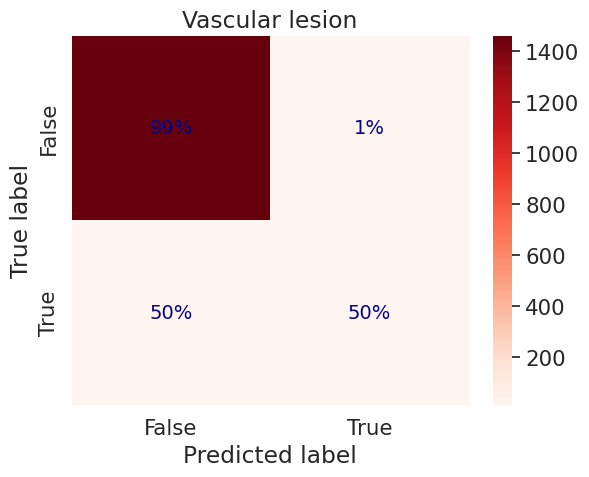

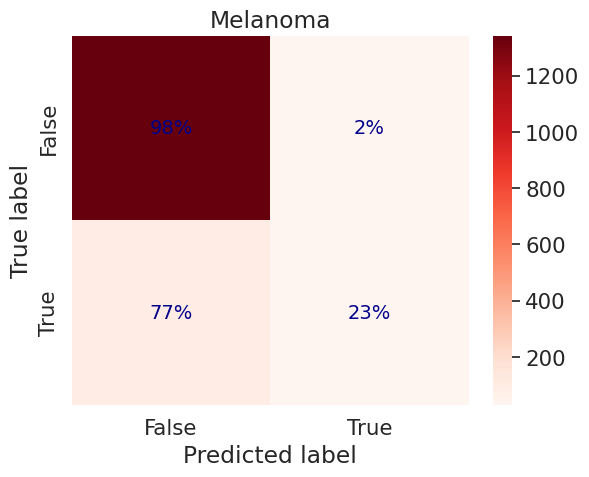

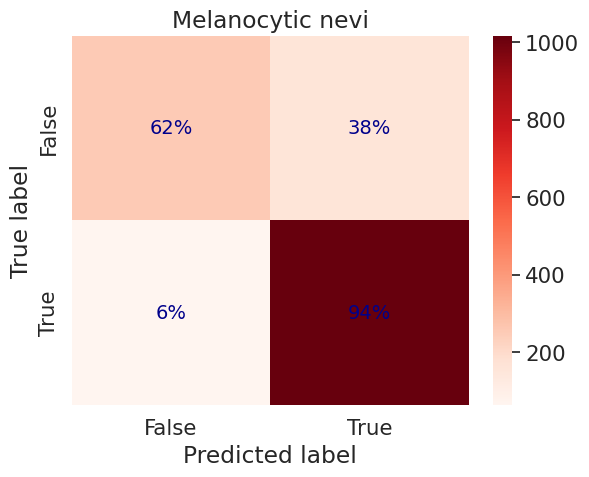

In [34]:
for metric, values in metrics.items():
    print(metric + ':\n')
    if 'Confusion_Matrix' in metric:
        for id, value in enumerate(values):
          sns.set(font_scale = 1.4) # Label size
          percentages = value / np.sum(value, axis = 1, keepdims = True)
          sns.heatmap(value, annot = False, cmap = "Reds")
          ax = plt.gca()
          for i in range(len(value)):
              for j in range(len(value)):
                  ax.text(j + 0.5, i + 0.5, f'{percentages[i, j]*100:.0f}%', # {value[i, j]:0d} ({percentages[i, j]*100:.0f}%)
                          ha = 'center',
                          va = 'center',
                          color = 'darkBlue',
                          fontsize = 14)
          ax.set_yticklabels(['False', 'True'])
          ax.set_xticklabels(['False', 'True'])
          plt.title(f'{labels[id]}')
          plt.ylabel('True label')
          plt.xlabel('Predicted label')
          plt.show()
    else:
        for id, value in enumerate(values):
            df = pd.DataFrame({'Label': labels, 'Value': values})
        print(df.to_string(index = False, col_space = 10, justify = 'center'))
    print('\n')

In [35]:
model.save(''.join([savePath, saveName, '.h5']))
if minMaxScalerNorm:
    joblib.dump(minMaxScaler, ''.join([savePath, saveName, 'MMscaler.pkl']))
elif standardScalerNorm:
    joblib.dump(standardScaler, ''.join([savePath, saveName, 'StdScaler.pkl']))

ValueError: Device /job:localhost/replica:0/task:0/device:CPU:0 is not found